# Imports 

In [1]:
%matplotlib inline

import sys
sys.path.append("../src")

import glob
import copy
import aplpy
import numpy
import scipy
import colorcet
import peakutils
import matplotlib
from scipy import ndimage
from matplotlib import pyplot
# pyplot.switch_backend("Qt4Agg")
from astropy.io import ascii, fits

import parse
import convert

from cluster import Cluster
from simulation import Simulation
from parse import psmac2_fitsfile
from rotate import apply_projection
from parse import toycluster_icfile
from main import new_argument_parser
# from plotsettings import PlotSettings
# style = PlotSettings()

def p2(a):
    return ((a) * (a))

pyplot.switch_backend("module://ipykernel.pylab.backend_inline")

/usr/local/AMUSE/prerequisites-10.0/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# LSS Parms

In [2]:
# First we find observed CygA centroid, and 'boxsize'
lss_Lx = "/usr/local/mscproj/runs/ChandraObservation/lss/cygnus_lss_fill_flux_2Msec.fits"
lss_kT = "/usr/local/mscproj/runs/ChandraObservation/lss/working_spectra_kT_map_2Msec.fits"
mosaic_Lx = fits.open(lss_Lx)
mosaic_kT = fits.open(lss_kT)
contour_smooth = scipy.ndimage.filters.gaussian_filter(mosaic_Lx[0].data, 25)
kT_smooth = scipy.ndimage.filters.gaussian_filter(mosaic_kT[0].data, 9)

# Find the centroid of CygA to align simulation and observation later on
maxcounts_obs = mosaic_Lx[0].data.max()
maxcounts_obs_index = mosaic_Lx[0].data.argmax()  # of flattened array
ylen_obs_pix, xlen_obs_pix = mosaic_Lx[0].data.shape
xcenter_obs = maxcounts_obs_index % xlen_obs_pix
ycenter_obs = maxcounts_obs_index / xlen_obs_pix

# Find the dimensions of the Chandra image in pix, arcsec and kpc
xlen_obs_pix = mosaic_Lx[0].header["NAXIS1"]  # same as using mosaic_smooth.shape
ylen_obs_pix = mosaic_Lx[0].header["NAXIS2"]
pix2arcsec_obs = mosaic_Lx[0].header["CDELT2"]*3600  # Chandra size of pixel 0.492". Value in header is in degrees.
xlen_obs_arcsec = xlen_obs_pix * pix2arcsec_obs
ylen_obs_arcsec = ylen_obs_pix * pix2arcsec_obs
from cosmology import CosmologyCalculator
cc = CosmologyCalculator(0.0562)
arcsec2kpc = cc.kpc_DA
pix2kpc_obs = pix2arcsec_obs * arcsec2kpc
xlen_obs_kpc = xlen_obs_arcsec * arcsec2kpc
ylen_obs_kpc = ylen_obs_arcsec * arcsec2kpc
zlen_obs_kpc = ylen_obs_kpc

print "Chandra Observation [lss_fill_flux]"
print "  Shape ({0},   {1})   pixels".format(xlen_obs_pix, ylen_obs_pix)
print "  Shape ({0:.1f}, {1:.1f}) arcsec".format(xlen_obs_arcsec, ylen_obs_arcsec)
print "  Shape ({0:.1f}, {1:.1f}) kpc".format(xlen_obs_kpc, ylen_obs_kpc)
print "  CygA at ({0}, {1}) pixels. Value = {2:2.2g}".format(xcenter_obs, ycenter_obs, maxcounts_obs)


Chandra Observation [lss_fill_flux]
  Shape (2051,   2151)   pixels
  Shape (1009.1, 1058.3) arcsec
  Shape (1100.6, 1154.3) kpc
  CygA at (665, 576) pixels. Value = 7.4e-05


## Lx function

In [3]:
def build_bestfit_stagelast_Lx(lss_Lx, set_the_stage=True):
    pyplot.rcParams.update( { "text.usetex": False, "font.size": 16 } )

    cygA = ( 299.8669, 40.734496 )
    cygNW = ( 299.7055, 40.884849 )

    gc = aplpy.FITSFigure(lss_Lx)
    gc.show_colorscale(vmin=5.0e-10, vmax=1.0e-7, stretch="log",
        cmap=colorcet.cm["linear_bmw_5_95_c86"], smooth=9)
    cygA_x, cygA_y = gc.world2pixel(cygA[0], cygA[1])
    cygNW_x, cygNW_y = gc.world2pixel(cygNW[0], cygNW[1])

    if not set_the_stage:
        # Add scale. Length is 500 kpc after unit conversions
        gc.add_scalebar(0.13227513)
        gc.scalebar.set_corner("bottom right")
        gc.scalebar.set_length(0.1)
        gc.scalebar.set_linewidth(4)
        gc.scalebar.set_font_size(22)
        gc.scalebar.set_label("500 kpc")
        gc.scalebar.set_color("white")

    # Pretty notation on the axes
    gc.tick_labels.set_xformat("hh:mm:ss")
    gc.tick_labels.set_yformat("dd:mm")
    gc.frame.set_color("white")

    ax = pyplot.gca()
    ax.tick_params(axis="both", which="both", reset=True, color="w", labelcolor="k",
        pad=8, width=2, size=4, direction="in", top="on", right="on")
    ax.tick_params(axis="both", which="major", size=8)

    if not set_the_stage:
        # CygA and CygNW label
        ax.text(cygA_x, 0.60*cygA_y, "CygA", weight="bold",
                ha="center", va="center", color="white", fontsize=22)
        ax.text(cygNW_x, 1.12*cygNW_y, "CygNW", ha="center", va="center",
                color="white", weight="bold", fontsize=22)

    pyplot.xlabel("RA (J2000)")
    ax.xaxis.set_tick_params(labeltop="on", labelbottom="off")
    ax.xaxis.set_label_position("top")
    pyplot.ylabel("Dec (J2000)")
    start, end = ax.get_xlim()
    # ax.xaxis.set_ticks([0, 500, 1000, 1500, 2000], 'top')

    cax = pyplot.colorbar(gc.image, ax=ax, shrink=0.45, pad=0.03,
                          aspect=12, orientation="horizontal")
    cax.ax.xaxis.set_ticks_position("both")
    cax.ax.tick_params(axis="both", length=6, width=1, labelsize=16)
    cax.ax.set_xlabel(r"X-ray Surface Brightness $\left[\frac{\mathrm{counts}}{\mathrm{cm}^2 \, \mathrm{s}} \right]$", fontsize=18)
    
    # Yes we must set ticks manually... +_+
    cax.set_ticks([1e-9, 1e-8, 1e-7])
    cax.set_ticklabels(["$10^{-9}$", "$10^{-8}$", "$10^{-7}$"])
    cax.ax.minorticks_on()
    minorticks = gc.image.norm(numpy.hstack([numpy.arange(5, 10, 1)/1e10,
        numpy.arange(2, 10, 1)/1e9, numpy.arange(2, 10, 1)/1e8]))
    cax.ax.tick_params(which="minor", length=3, width=1, direction="in")
    cax.ax.xaxis.set_ticks(minorticks, minor=True)

    for label in ax.get_ymajorticklabels() + ax.get_yminorticklabels():
        label.set_rotation_mode("anchor")
        label.set_rotation(90)
        label.set_horizontalalignment("center")

    # For some reason shows up double...
    ax.tick_params(axis="both", which="both", top="off", right="off")
    
    pyplot.savefig("out/obs_Lx.pdf", bbox_inches="tight")
    pyplot.savefig("out/obs_Lx.png", dpi=600, bbox_inches="tight")
    return pyplot.gcf(), ax, cax

## kT function

In [4]:
def build_bestfit_stagelast_kT(lss_kT, set_the_stage=True):
    pyplot.rcParams.update( { "text.usetex": False, "font.size": 16 } )

    cygA = ( 299.8669, 40.734496 )
    cygNW = ( 299.7055, 40.884849 )

    gc = aplpy.FITSFigure(lss_kT)
    gc.show_colorscale(vmin=3.5, vmax=12, stretch="linear",
        cmap=colorcet.cm["linear_kryw_5_100_c67"], smooth=9)
    cygA_x, cygA_y = gc.world2pixel(cygA[0], cygA[1])
    cygNW_x, cygNW_y = gc.world2pixel(cygNW[0], cygNW[1])

    if not set_the_stage:
        # Add scale. Length is 500 kpc after unit conversions
        gc.add_scalebar(0.13227513)
        gc.scalebar.set_corner("bottom right")
        gc.scalebar.set_length(0.1)
        gc.scalebar.set_linewidth(4)
        gc.scalebar.set_font_size(22)
        gc.scalebar.set_label("500 kpc")
        gc.scalebar.set_color("white")

    # Pretty notation on the axes
    gc.tick_labels.set_xformat("hh:mm:ss")
    gc.tick_labels.set_yformat("dd:mm")
    gc.frame.set_color("white")

    ax = pyplot.gca()
    ax.tick_params(axis="both", which="both", reset=True, color="w", labelcolor="k",
        pad=8, width=2, size=4, direction="in", top="on", right="on")
    ax.tick_params(axis="both", which="major", size=8)

    if not set_the_stage:
        # CygA and CygNW label
        ax.text(cygA_x, 0.80*cygA_y, "CygA", weight="bold",
                ha="center", va="center", color="white", fontsize=22)
        ax.text(cygNW_x, 1.12*cygNW_y, "CygNW", ha="center", va="center",
                color="white", weight="bold", fontsize=22)

    pyplot.xlabel("RA (J2000)")
    ax.xaxis.set_tick_params(labeltop="on", labelbottom="off")
    ax.xaxis.set_label_position("top")
    pyplot.ylabel("Dec (J2000)")
    start, end = ax.get_xlim()
    # ax.xaxis.set_ticks([0, 500, 1000, 1500, 2000], 'top')

    cax = pyplot.colorbar(gc.image, ax=ax, shrink=0.45, pad=0.03,
                          aspect=12, orientation="horizontal")
    cax.ax.xaxis.set_ticks_position("both")
    cax.ax.tick_params(axis="both", length=6, width=1, labelsize=16)
    cax.ax.set_xlabel(r"Temperature [keV]", fontsize=18)

    cax.ax.tick_params(which="minor", length=3, width=1, direction="in")

    for label in ax.get_ymajorticklabels() + ax.get_yminorticklabels():
        label.set_rotation_mode("anchor")
        label.set_rotation(90)
        label.set_horizontalalignment("center")

    # Fo r some reason shows up double...
    ax.tick_params(axis="both", which="both", top="off", right="off")
    
    pyplot.savefig("out/obs_kT.pdf", bbox_inches="tight")
    pyplot.savefig("out/obs_kT.png", dpi=600, bbox_inches="tight")
    return pyplot.gcf(), ax, cax

## Lx image 

/usr/local/AMUSE/prerequisites-10.0/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:


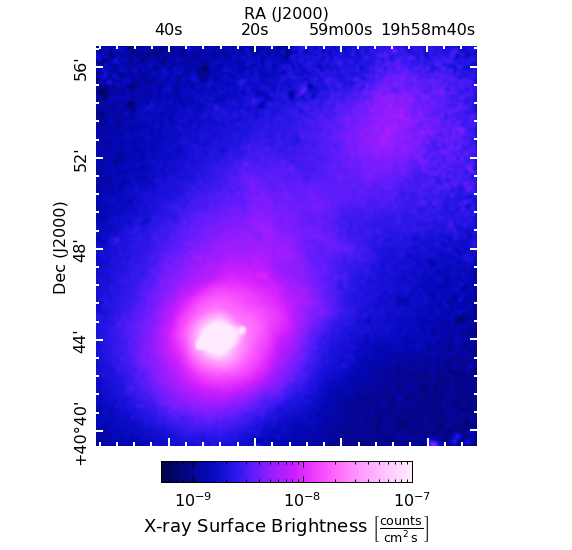

In [5]:
pyplot.rcParams.update( { "text.usetex": False } )
fig_Lx, ax_Lx, cax_Lx = build_bestfit_stagelast_Lx(lss_Lx)

## kT image 

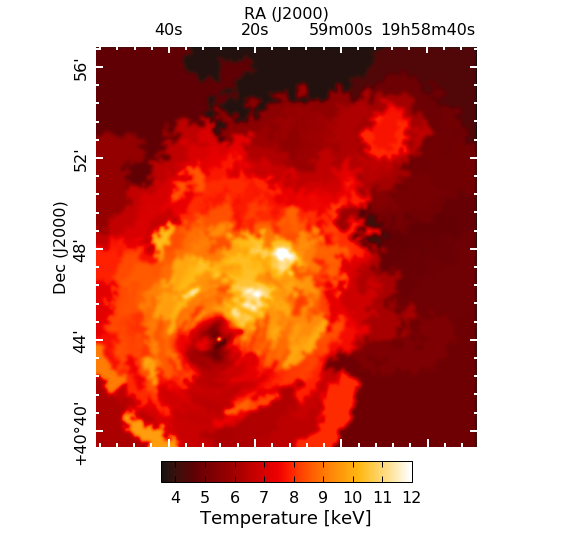

In [6]:
pyplot.rcParams.update( { "text.usetex": False } )
fig_kT, ax_kT, cax_kT = build_bestfit_stagelast_kT(lss_kT)

# Simulation

## Distance function

In [7]:
def get_core_separation(H, pixelscale, i, verbose=False):
    xhalf = H.shape[0]//2
    left, right = numpy.hsplit(H, 2)
    idx1 = list(left.flatten()).index(left.max())
    cygA = idx1 % left.shape[1], idx1 / left.shape[1]

    idx2 = list(right.flatten()).index(right.max())
    cygNW = idx2 % right.shape[1] + xhalf, idx2 / right.shape[1]
    
    distance = numpy.sqrt(p2(cygA[0]-cygNW[0])+p2(cygA[1]-cygNW[1]))
    distance *= pixelscale

    if verbose:
        print "Peaks for i = {0}".format(i)
        print "  cygA:  (x, y) = {0}".format(cygA)
        print "  cygNW: (x, y) = {0}".format(cygNW)
        print "  distance      = {0:.2f} kpc\n".format(distance)

    pyplot.figure()
    pyplot.imshow(numpy.log10(H), origin="lower")
    pyplot.plot(cygA[0], cygA[1], "rX", ms=5)
    pyplot.plot(cygNW[0], cygNW[1], "rX", ms=5)
    pyplot.xticks([],[]); pyplot.yticks([],[])
    pyplot.savefig("out/peakfind_{0:03d}.pdf".format(i), bbox_inches="tight")
    pyplot.close()
        
    return cygA, cygNW, distance

## Plot function 

In [8]:
pyplot.rcParams.update( { "text.usetex": True, "font.size": 16 } )

def build_bestfit(i, Lx, kT, xlen, ylen, pix2kpc_sim, 
        time, outdir, pix2kpc_obs, arcsec2kpc,
        fig_Lx, ax_Lx, fig_kT, ax_kT, stage="1", EA1=0, EA2=0):
    """ Stage 1: snapshot_000 snapshot_147 3
        Stage 2: snapshot_147_000 snapshot_147_010 1 [end at 9!]
        Stage 3: Euler_Angle_1 0 51 3
        Stage 3: Euler_Angle_2 0 45 3 """

    #### Build Lx ####
    # First, get some parameters from the observation to ensure
    # equal smoothing and limits to the imshow of Smac Lx/kT
    magic = 5.82e-9 / 1.77e-5 
    smooth_obs_kpc = 9 * pix2kpc_obs * arcsec2kpc
    smooth_sim_kpc = smooth_obs_kpc / pix2kpc_sim
    
    (xmin, xmax), (ymin, ymax) = ax_Lx.get_xlim(), ax_Lx.get_ylim()
    Lx_smooth = magic*scipy.ndimage.filters.gaussian_filter(
        Lx, smooth_sim_kpc)
    im = ax_Lx.imshow(#numpy.ma.masked_less_equal(Lx_smooth, 5.0e-10),
        Lx_smooth, extent=[xmin, xmax, ymin, ymax],
        origin="lower", vmin=5.0e-10, vmax=1.0e-7,
        cmap=colorcet.cm["linear_bmw_5_95_c86"],
        norm=matplotlib.colors.LogNorm())
    # Hide observer units on axes
    ax_Lx.tick_params(axis="both", colors="white")
    ax_Lx.xaxis.label.set_color("white")
    ax_Lx.yaxis.label.set_color("white")
        
    #### Build kT ####
    (xmin, xmax), (ymin, ymax) = ax_kT.get_xlim(), ax_kT.get_ylim()
    kT_smooth = scipy.ndimage.filters.gaussian_filter(
        convert.K_to_keV(kT), smooth_sim_kpc) 
    im = ax_kT.imshow(#numpy.ma.masked_less_equal(kT_smooth, 3.5),
        kT_smooth, extent=[xmin, xmax, ymin, ymax],
        origin="lower", vmin=3.5, vmax=12,
        cmap=colorcet.cm["linear_kryw_5_100_c67"])
    # Hide observer units on axes
    ax_kT.tick_params(axis="both", colors="white")
    ax_kT.xaxis.label.set_color("white")
    ax_kT.yaxis.label.set_color("white")
    
    cygA, cygNW, distance = get_core_separation(Lx, pix2kpc_sim, i)
    texts = []
    # texts.append(ax_Lx.plot(cygA[0]*(xmax-xmin)/xlen,
    #     cygA[1]*(ymax-ymin)/ylen, "rX", ms=5))
    # texts.append(ax_Lx.plot(cygNW[0]*(xmax-xmin)/xlen,
    #     cygNW[1]*(ymax-ymin)/ylen, "rX", ms=5))
    # texts.append(ax_kT.plot(cygA[0]*(xmax-xmin)/xlen,
    #     cygA[1]*(ymax-ymin)/ylen, "rX", ms=5))
    # texts.append(ax_kT.plot(cygNW[0]*(xmax-xmin)/xlen,
    #     cygNW[1]*(ymax-ymin)/ylen, "rX", ms=5))
    
    # Toss in some simulation numbers    
    scale = xlen*pix2kpc_sim
    scale = "[{0:.1f} Mpc]$^2$".format(float(scale)/1000)
    pad = 50

    # Set Time + Distance        
    timedistance = r"\begin{tabular}{p{1.75cm}ll}"
    timedistance += r" time & = & {0:<07.4f} Gyr \\".format(time)
    timedistance += " distance & = & {0:<06.2f} kpc \\\\".format(distance)
    timedistance += (" \end{tabular}")
    
    texts.append(ax_Lx.text(0.5, 0.98, timedistance,
        size=18, color="white", ha="center", va="top",
        transform=ax_Lx.transAxes))
    texts.append(ax_kT.text(0.5, 0.98, timedistance,
        size=18, color="white", ha="center", va="top",
        transform=ax_kT.transAxes))

    # Set Scale indicator
    texts.append(ax_kT.text(2*pad, pad, scale, size=16,
        color="white", ha="left", va="bottom"))
    texts.append(ax_Lx.text(2*pad, pad, scale, size=16,
        color="white", ha="left", va="bottom"))
    
    # Set Euler Angles
    EA0 = 90
    angles = r"\begin{tabular}{p{1.25cm}ll}"
    angles += r" EA0 & = & {0:03d} \\".format(EA0)
    angles += " EA1 & = & {0:03d} \\\\".format(EA1)
    angles += " EA2 & = & {0:03d} \\\\".format(EA2)
    angles += (" \end{tabular}")
    
    texts.append(ax_Lx.text(xmax-2*pad, pad, angles, size=16,
        color="white", ha="right", va="bottom"))
    texts.append(ax_kT.text(xmax-2*pad, pad, angles, size=16,
        color="white", ha="right", va="bottom"))
    
    fig_Lx.savefig("out/sim_Lx_{0:03d}.png".format(i), bbox_inches="tight", dpi=600)
    fig_kT.savefig("out/sim_kT_{0:03d}.png".format(i), bbox_inches="tight", dpi=600)
   
    for txt in texts:
        if isinstance(txt, list) and len(txt) == 1:
            txt = txt[0]
        txt.remove()
        
    # pyplot.close(fig)
    # pyplot.show()

### Stage 1: varying time 

In [14]:
simdir = "/Volumes/Cygnus/timoh/runs/20170115T0907/"
smacdir = simdir + "analysis/"
outdir = simdir + "out/"

Lx_stage1 = smacdir + "BestFitSimulation_Stage1_BestTime_Lx.fits.fz"
kT_stage1 = smacdir + "BestFitSimulation_Stage1_BestTime_kT.fits.fz"

header, Lx = psmac2_fitsfile(Lx_stage1)
header2, kT = psmac2_fitsfile(kT_stage1)
nsnap, xlen, ylen = kT.shape
pix2kpc_sim = float(header["XYSize"])/int(xlen)

# For regular snapshots
dt = 0.01
# For finer interpolation
dt_finer = dt/40 

print("nsnap      : {0}\nxlen       : {1}\nylen       : {2}"\
      .format(nsnap, xlen, ylen))
print("dt         : {0}".format(dt))
print("pix2kpc_sim: {0:.3f}".format(pix2kpc_sim))
print("pix2kpc_obs: {0:.3f}".format(pix2kpc_obs))
print("arcsec2kpc : {0:.3f}".format(arcsec2kpc))
print("")

for i in range(nsnap):
    time = 0 + 3*i * dt
    print("{0:03d}: {1:04.6f}".format(i, time))
    continue
    build_bestfit(i, Lx[i], kT[i], xlen, ylen, pix2kpc_sim,
        time, outdir, pix2kpc_obs, arcsec2kpc,
        fig_Lx, ax_Lx, fig_kT, ax_kT, stage="1")

nsnap      : 50
xlen       : 2048
ylen       : 2048
dt         : 0.01
pix2kpc_sim: 3.024
pix2kpc_obs: 0.537
arcsec2kpc : 1.091

000: 0.000000
001: 0.030000
002: 0.060000
003: 0.090000
004: 0.120000
005: 0.150000
006: 0.180000
007: 0.210000
008: 0.240000
009: 0.270000
010: 0.300000
011: 0.330000
012: 0.360000
013: 0.390000
014: 0.420000
015: 0.450000
016: 0.480000
017: 0.510000
018: 0.540000
019: 0.570000
020: 0.600000
021: 0.630000
022: 0.660000
023: 0.690000
024: 0.720000
025: 0.750000
026: 0.780000
027: 0.810000
028: 0.840000
029: 0.870000
030: 0.900000
031: 0.930000
032: 0.960000
033: 0.990000
034: 1.020000
035: 1.050000
036: 1.080000
037: 1.110000
038: 1.140000
039: 1.170000
040: 1.200000
041: 1.230000
042: 1.260000
043: 1.290000
044: 1.320000
045: 1.350000
046: 1.380000
047: 1.410000
048: 1.440000
049: 1.470000


### Stage 2: varying time /w finer interpolation

In [ ]:
Lx_stage2 = smacdir + "BestFitSimulation_Stage1_BestTime_Lx_finer.fits.fz"
kT_stage2 = smacdir + "BestFitSimulation_Stage1_BestTime_kT_finer.fits.fz"

header, Lx = psmac2_fitsfile(Lx_stage2)
header2, kT = psmac2_fitsfile(kT_stage2)
nsnap, xlen, ylen = Lx.shape

t0 = 147 * dt
for i in range(1, nsnap-1):
    time = t0 + i * dt_finer
    print("{0:03d}: {1:04.6f}".format(i+49, time))
    # continue
    build_bestfit(i+49, Lx[i], kT[i], xlen, ylen, pix2kpc_sim,
        time, outdir, pix2kpc_obs, arcsec2kpc,
        fig_Lx, ax_Lx, fig_kT, ax_kT, stage="2")

### Stage 3: varying Euler Angle 1 

In [ ]:
Lx_stage3 = smacdir + "BestFitSimulation_Stage1_BestTime_Lx_EA1.fits.fz"
kT_stage3 = smacdir + "BestFitSimulation_Stage1_BestTime_kT_EA1.fits.fz"

header, Lx = psmac2_fitsfile(Lx_stage3)
header2, kT = psmac2_fitsfile(kT_stage3)
nsnap, xlen, ylen = Lx.shape

t0 = 147 * dt
time = t0 + 9 * dt_finer
for i in range(1, nsnap):
    EA1 = i * 3
    print("{0:03d}: {1:04.6f} --> {2}".format(i+49+9, time, EA1))
    # continue
    build_bestfit(i+49+9, Lx[i], kT[i], xlen, ylen, pix2kpc_sim,
        time, outdir, pix2kpc_obs, arcsec2kpc,
        fig_Lx, ax_Lx, fig_kT, ax_kT, stage="3", EA1=EA1)

### Stage 4: varying Euler Angle 2

In [ ]:
Lx_stage3 = smacdir + "BestFitSimulation_Stage1_BestTime_Lx_EA2.fits.fz"
kT_stage3 = smacdir + "BestFitSimulation_Stage1_BestTime_kT_EA2.fits.fz"

header, Lx = psmac2_fitsfile(Lx_stage3)
header2, kT = psmac2_fitsfile(kT_stage3)
nsnap, xlen, ylen = Lx.shape

t0 = 147 * dt
time = t0 + 9 * dt_finer
EA1 = 51
for i in range(1, nsnap):
    EA2 = i * 3
    print("{0:03d}: {1:04.6f} --> {2}, {3}".format(i+49+9+17, time, EA1, EA2))
    # continue
    build_bestfit(i+49+9+17, Lx[i], kT[i], xlen, ylen, pix2kpc_sim,
        time, outdir, pix2kpc_obs, arcsec2kpc,
        fig_Lx, ax_Lx, fig_kT, ax_kT, stage="4", EA1=EA1, EA2=EA2)

076: 1.472250 --> 51, 3
077: 1.472250 --> 51, 6
078: 1.472250 --> 51, 9
079: 1.472250 --> 51, 12
080: 1.472250 --> 51, 15
081: 1.472250 --> 51, 18
082: 1.472250 --> 51, 21
083: 1.472250 --> 51, 24
084: 1.472250 --> 51, 27
085: 1.472250 --> 51, 30
086: 1.472250 --> 51, 33
087: 1.472250 --> 51, 36
088: 1.472250 --> 51, 39
089: 1.472250 --> 51, 42


### Stage 5: Place fidicial CygA at same point

### Stage 6: Zoom into Simulation Box

### Stage 7: Morph Simulation into Observation

In [ ]:
pyplot.rcParams.update( { "text.usetex": False } )
fig_Lx, ax_Lx, cax_Lx = build_bestfit_stagelast_Lx(lss_Lx, set_the_stage=False)

pyplot.rcParams.update( { "text.usetex": False } )
fig_kT, ax_kT, cax_kT = build_bestfit_stagelast_kT(lss_kT, set_the_stage=False)